In [1]:
import os
import sys
import matplotlib.pyplot as plt
import random
from copy import deepcopy
from datetime import datetime, timedelta


dir = os.path.split(os.getcwd())[0]
if dir not in sys.path:
    sys.path.append(dir)

from model import Course
from controller import search_classes
from useful_functions import schedule_generator, valid_schedule, time_of_day_score
from hillclimbing import energy_function

In [2]:
example_schedule = [
    "ACCT1209"
]

courses = []
for course in example_schedule:
    banner_courses = search_classes(course[:-4], course[-4:])

    assert len(banner_courses) > 0, "Course doesn't exist or isn't in the spring 2024 semester"
    
    courses.append(banner_courses)

In [3]:
for course in courses[0]:
    if course.is_async():
        print("ASYNC")

ASYNC
ASYNC
ASYNC
ASYNC
ASYNC
ASYNC
ASYNC
ASYNC


In [24]:
random_schedule = schedule_generator(courses)

In [68]:
def hillclimb(schedule, tod_pref, day_off_pref, time_betweem_pref, iterations, all_courses):
    energy__time = []
    # variables to hold the best results 
    best_solution = deepcopy(schedule)
    best_energy = energy_function(schedule, tod_pref, day_off_pref, time_betweem_pref)
    num_classes = len(schedule)
    
    for _ in range(iterations):
        #a random class index in the schedule and num of possible courses for that class
        class_idx = random.randint(0, num_classes-1)
        num_courses = len(all_courses[class_idx])
        
        # copy of the current best maze
        new_schedule = deepcopy(best_solution)

        # upating the random class to be a random course form the 2d list of all courses
        new_schedule[class_idx] = all_courses[class_idx][random.randint(0,num_courses-1)]

        # prevents the tile change from creating an unsolvable maze
        while not valid_schedule(new_schedule):
            new_schedule[class_idx] = all_courses[class_idx][random.randint(0,num_courses-1)]

        # finds the energy value of the new maze
        new_energy = energy_function(new_schedule, tod_pref, day_off_pref, time_betweem_pref)
        # compares the new energy value to the previous best
        if  new_energy > best_energy:
            best_solution = deepcopy(new_schedule)
            best_energy = new_energy

        energy__time.append(best_energy)



    return best_solution, best_energy, energy__time

        
def hillclimb_random_restarts(schedule, tod_pref, day_off_pref, time_betweem_pref, iterations, num_restarts, all_courses):
    # variables to hold the best results 
    best_solution = deepcopy(schedule)

    best_energy = energy_function(schedule, tod_pref, day_off_pref, time_betweem_pref)
    energy__time_restart = []
    for _ in range(num_restarts):
        new_solution, new_energy, energy__time = hillclimb(schedule, tod_pref, day_off_pref, time_betweem_pref, iterations, all_courses)

        energy__time_restart.append(energy__time)
        if new_energy > best_energy:
            best_solution = deepcopy(new_solution)
            best_energy = new_energy
            best_energy__time = energy__time

    return best_solution, best_energy, energy__time_restart, best_energy__time


In [69]:
time_preference = "m"
day_off = "mon"
time_between = 10


best_solution, best_energy, energy__time = hillclimb(random_schedule, time_preference, day_off, time_between, 1000, courses)
best_solution, best_energy, energy__time_restarts, best_energy__time = hillclimb_random_restarts(random_schedule, time_preference, day_off, time_between, 300, 20, courses)

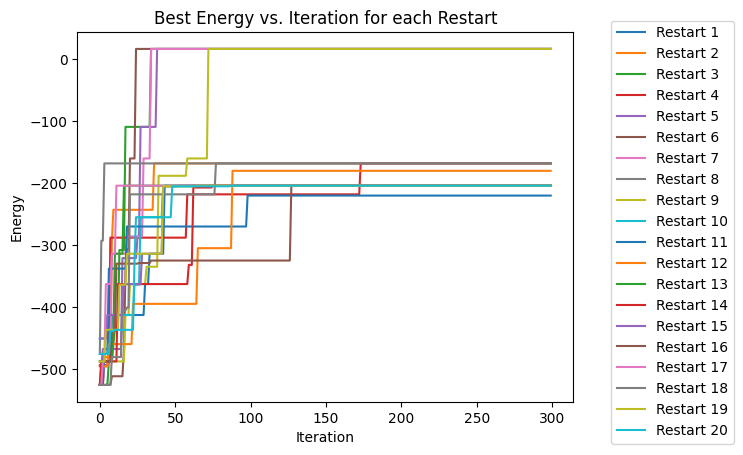

In [119]:
# 
for hill_climb_data in energy__time_restarts:
    plt.plot(hill_climb_data)

# plt.plot(energy__time)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Best Energy vs. Iteration for each Restart')
plt.legend([f'Restart {i+1}' for i in range(len(energy__time_restart))], loc='upper center', bbox_to_anchor=(1.2, 1.05))
plt.savefig("./data/all_energies.png", bbox_inches="tight")

plt.show()



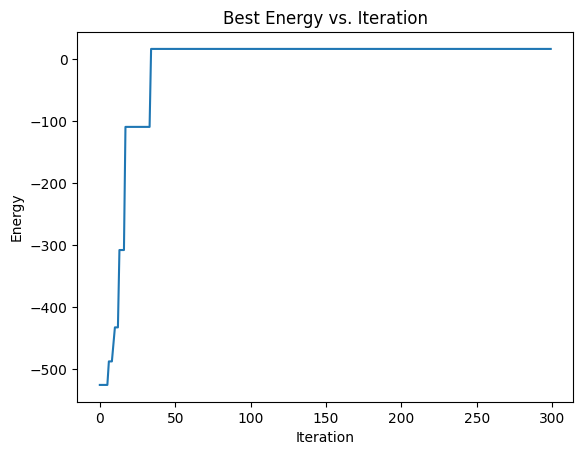

In [117]:
plt.plot(best_energy__time)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Best Energy vs. Iteration')


plt.savefig("./data/best_energy.png")
plt.show()

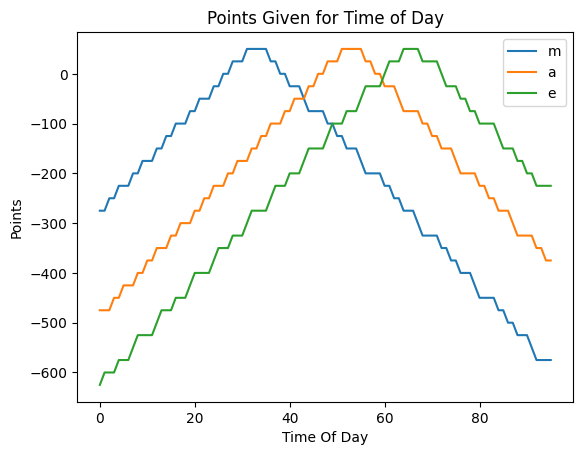

In [114]:
# how start time impacts time of day score
points_for_tods = {
    "m": [],
    "a": [],
    "e": []
}

for tod_pref, points_for_tod in points_for_tods.items():
    start_datetime = datetime(2023, 1, 1, 0, 0, 0)
    end_datetime = start_datetime + timedelta(hours=24)
    hour_interval = timedelta(minutes=15)

    # Loop through all datetimes in the 24-hour period
    current_datetime = start_datetime
    while current_datetime < end_datetime:
        points_for_tod.append(time_of_day_score(current_datetime.strftime("%H%M"), tod_pref))
        current_datetime += hour_interval

    plt.plot(points_for_tod, label=tod_pref")


plt.xlabel('Time Of Day')
plt.ylabel('Points')
plt.title('Points Given for Time of Day')
plt.legend()
plt.show()
